In [1]:
import awkward0
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import numpy as np
import awkward
import awkward0
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

### k-nearest neighbors
construct graph data using knn algorithm

In [2]:
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)

### Edge Convulution operation
Attention: use (1,1) kernel Conv2D to perform MLP

In [3]:
def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='average', name='edgeconv'):
    """EdgeConv
    Args:
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
        indices = indices[:, :, 1:]  # (N, P, K)

        fts = features
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C)
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C)

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='HeNormal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='HeNormal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts

### ParticleNetLite++
Base architecture

In [4]:
def _particle_net_base(points, features=None, mask=None, setting=None, name='particle_net'):
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optinal

    with tf.name_scope(name):
        if features is None:
            features = points

        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99

        fts = tf.squeeze(keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)), axis=2)
        for layer_idx, layer_param in enumerate(setting.conv_params):
            K, channels = layer_param
            pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))

        if mask is not None:
            fts = tf.multiply(fts, mask)

        pool = tf.reduce_mean(fts, axis=1)  # (N, C)

        if setting.fc_params is not None:
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(1, activation='sigmoid')(x)
            return out  # (N, num_classes)
        else:
            return pool

class _DotDict:
    pass

### ParticleNetLite++
Change parameters here:

1. number of neighbors of knn

2. params of MLP in EdgeConv

3. Global pooling operation

4. number of neurons in dense layer

5. dropout rate

In [5]:
def get_particle_net_lite(num_classes, input_shapes):
    r"""
    num_classes : int
        Number of output classes.
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (7, (4, 4, 4)),
        (7, (8, 8, 8)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [(16, None)]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='ParticleNet')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')


#### Stack and pad arrays

In [6]:
import logging

logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def stack_arrays(a, keys, axis=-1):
    flat_arr = np.stack([a[k].flatten() for k in keys], axis=axis)
    return awkward.JaggedArray.fromcounts(a[keys[0]].counts, flat_arr)

def pad_array(a, maxlen, value=0., dtype='float64'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
        if not len(s):
            continue
        trunc = np.array(s[:maxlen]).astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x

### Adjust dataset

In [7]:
class Dataset(object):

    def __init__(self, filepath, feature_dict = {}, label='label', pad_len=100, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict)==0:
            feature_dict['points'] = ['eta_array', 'phi_array']
            feature_dict['features'] = ['eta_array', 'phi_array', 'pT_array']
            feature_dict['mask'] = ['pT_array']
            #"eta_array": b,"phi_array": c,"pT_array"
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()

    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        counts = None
        with awkward0.load(self.filepath) as a:
            
            self._label = a[self.label]
            for k in self.feature_dict:
                cols = self.feature_dict[k]
                if not isinstance(cols, (list, tuple)):
                    cols = [cols]
                arrs = []
                for col in cols:
                    if counts is None:
                        counts = awkward.count(a[col],axis=None)
                    else:
                        assert np.array_equal(counts, awkward.count(a[col],axis=None))
                    arrs.append(pad_array(a[col], self.pad_len))
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)


    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

### Load Dataset
Change path to your train dataset ( train + validation )

In [8]:
dataset = Dataset('/software/dg22882/ParticleNet/Dataset/150000_max_sorted_train_dataset_experiments_abseta3.awkd', data_format='channel_last')

[2022-08-22 22:47:41,262] INFO: Start loading file /software/dg22882/ParticleNet/Dataset/150000_max_sorted_train_dataset_experiments_abseta3.awkd
[2022-08-22 22:47:55,589] INFO: Finished loading file /software/dg22882/ParticleNet/Dataset/150000_max_sorted_train_dataset_experiments_abseta3.awkd


In [9]:
model_name = 'model_exp_19'        #set your model (file) name
num_classes = 2                    #our task is binary classification so we only have two classes
input_shapes = {k:np.shape(dataset[k])[1:] for k in dataset.X}
model = get_particle_net_lite(num_classes, input_shapes)

2022-08-22 22:47:57.433639: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 22:48:01.854932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13578 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-08-22 22:48:01.857083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13578 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-08-22 22:48:01.859011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/devi

### Learning Rate Strategy
We have two learning rate strategy: <b>constant learning rate</b> and <b>learning rate decay</b>.

Also set up your <b>batch size</b> here.

If you want to use <b>learning rate decay</b> strategy, don't forget to enter your number of training epochs and validation split ratio here.

In [10]:
num_epochs = 10
batch_size = 64
validation_split=0.25
num_train_steps = (len(dataset['points'])*(1-validation_split) // batch_size) * num_epochs

#Polynomial lr Decay
def lr_schedule(initial_learning_rate,end_learning_rate):
    lr = tf.keras.optimizers.schedules.PolynomialDecay(
       initial_learning_rate = initial_learning_rate,
       end_learning_rate = end_learning_rate,
       decay_steps = num_train_steps)
    return lr

#If you want to use constant lr, activate this function and deactivate the above one
'''def lr_schedule(lr):
    lr = lr
    return lr'''

'def lr_schedule(lr):\n    lr = lr\n    return lr'

### Set up optimizer and Learning rate here

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0.01,0.001)),    #you can change optimizer and lr here
              metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 100, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 100, 1)      0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 100, 1)       0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 100, 1)       0           ['tf.cast[0][0]']                
                                                                                        

In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath=f'/software/dg22882/ParticleNet/model_record/{model_name}',           #filepath
                             monitor='val_accuracy',
                             verbose=10,
                             save_best_only=True)         
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, progress_bar]

### Shuffle training dataset

In [13]:
dataset.shuffle()

### Train the model
Set <b>number of training epochs</b> and set <b>ratio</b> to split Dataset for training set and testing set. Start training.

In [14]:
history = model.fit(dataset.X, dataset.y,
          batch_size=batch_size,
          epochs=10,                                                    # --- set number of training epochs ---      
          validation_split=0.25,                                        # --- set ratio to split Dataset for training set and testing set ---
          shuffle=True,
          callbacks=callbacks)

model.save(f"/software/dg22882/ParticleNet/model_record/{model_name}")

Epoch 1/10


2022-08-22 22:48:07.105087: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-08-22 22:48:08.558399: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


      0/Unknown - 49s 0s/sample - loss: 0.0101 - accuracy: 0.9964
Epoch 1: val_accuracy improved from -inf to 0.99933, saving model to /software/dg22882/ParticleNet/model_record/model_exp_19


2022-08-22 22:49:07.484236: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /software/dg22882/ParticleNet/model_record/model_exp_19/assets


[2022-08-22 22:49:09,147] INFO: Assets written to: /software/dg22882/ParticleNet/model_record/model_exp_19/assets


1758/1758 [==============================] - 64s 37ms/sample - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0023 - val_accuracy: 0.9993
Epoch 2/10
   0/1758 [..............................] - ETA: 0s - loss: 0.0032 - accuracy: 0.9991
Epoch 2: val_accuracy did not improve from 0.99933
1758/1758 [==============================] - 54s 31ms/sample - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0027 - val_accuracy: 0.9991
Epoch 3/10
   0/1758 [..............................] - ETA: 0s - loss: 0.0026 - accuracy: 0.9993
Epoch 3: val_accuracy did not improve from 0.99933
1758/1758 [==============================] - 55s 31ms/sample - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 0.9992
Epoch 4/10
   0/1758 [..............................] - ETA: 0s - loss: 0.0023 - accuracy: 0.9994
Epoch 4: val_accuracy did not improve from 0.99933
1758/1758 [==============================] - 54s 31ms/sample - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1090 - val_accuracy: 0.9424
Epoch

[2022-08-22 22:57:17,508] INFO: Assets written to: /software/dg22882/ParticleNet/model_record/model_exp_19/assets


### Prediction
Set <b>testing dataset file path</b> here. Also we will save prediction scores which use to make plot.

In [22]:
import pickle

# Save training metrics
metrics = dict(history.history)
with open(f"/software/dg22882/ParticleNet/model_record/{model_name}/model_metrics.pickle", 'wb') as handle:
        pickle.dump(metrics , handle, protocol=4)
print(f"metrics saved: {model_name}")

metrics saved: model_exp_19


In [23]:
# Predict on test dataset
# Change path to testing dataset here
test_dataset = Dataset('/software/dg22882/ParticleNet/Dataset/50000_max_sorted_test_dataset_experiments_abseta3.awkd', data_format='channel_last')

[2022-08-22 23:03:19,262] INFO: Start loading file /software/dg22882/ParticleNet/Dataset/50000_max_sorted_test_dataset_experiments_abseta3.awkd
[2022-08-22 23:03:23,723] INFO: Finished loading file /software/dg22882/ParticleNet/Dataset/50000_max_sorted_test_dataset_experiments_abseta3.awkd


In [24]:
# Save to numpy files to use in make_plots2.py
scores = np.array(model.predict(test_dataset.X)).astype(np.float64)
np.save(f'/software/dg22882/ParticleNet/model_record/{model_name}/prediction_scores.npy', scores)
np.save('/software/dg22882/ParticleNet/Dataset/test_labels.npy', test_dataset.y)

### Simply visualize result

(array([2.1603e+04, 1.4000e+03, 7.9900e+02, 5.8500e+02, 3.6000e+02,
        1.2700e+02, 5.1000e+01, 2.3000e+01, 2.2000e+01, 2.5030e+04]),
 array([4.07159358e-04, 1.00366408e-01, 2.00325656e-01, 3.00284904e-01,
        4.00244153e-01, 5.00203401e-01, 6.00162649e-01, 7.00121897e-01,
        8.00081146e-01, 9.00040394e-01, 9.99999642e-01]),
 <BarContainer object of 10 artists>)

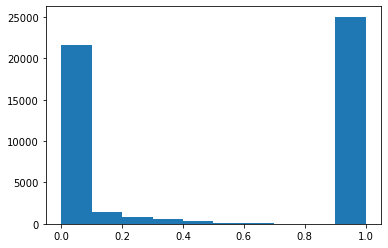

In [25]:
plt.hist(scores)